# How To Compute Volatility?

"Statistical volatility (also called historic or realized volatility) is a measurement of how much the price or returns of stock value. It’s used to optimize portfolios, detect regime changes, and price derivatives. The most common way to measure statistical volatility is the standard deviation."

https://www.pyquantnews.com/the-pyquant-newsletter/how-to-compute-volatility-6-ways

In [2]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [10]:
import math

import numpy as np
import yfinance as yf

data = yf.download("HDV", start="2021-01-01", end="2025-03-03")

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

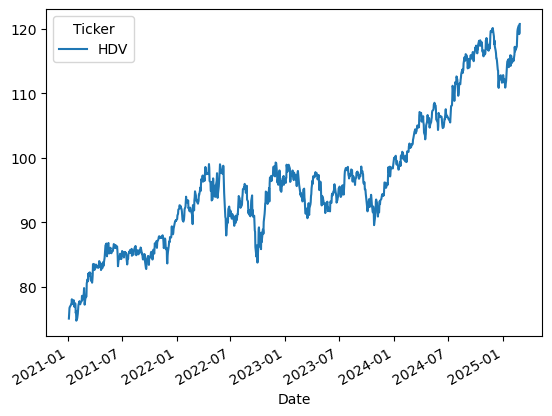

In [12]:
data['Close'].plot()

In [14]:
HDV = yf.Ticker("HDV")
HDV_data = HDV.history(period="4y")
print(HDV_data)

                                 Open        High         Low       Close  \
Date                                                                        
2021-03-05 00:00:00-05:00   79.417573   80.814649   79.193356   80.547310   
2021-03-08 00:00:00-05:00   81.004372   81.953001   80.711156   81.194099   
2021-03-09 00:00:00-05:00   81.314828   81.754649   80.849136   80.849136   
2021-03-10 00:00:00-05:00   81.159587   82.220324   81.150961   82.039223   
2021-03-11 00:00:00-05:00   82.125471   82.410055   81.582161   81.651154   
...                               ...         ...         ...         ...   
2025-02-26 00:00:00-05:00  120.190002  120.190002  118.919998  119.150002   
2025-02-27 00:00:00-05:00  119.150002  120.040001  118.900002  119.370003   
2025-02-28 00:00:00-05:00  119.629997  120.769997  119.120003  120.720001   
2025-03-03 00:00:00-05:00  120.709999  121.500000  119.680000  120.440002   
2025-03-04 00:00:00-05:00  120.150002  120.610001  118.870003  118.879997   

# Standard Deviation
Standard deviation is a statistical measurement that looks at how far individual points in a dataset are dispersed from the mean of that set. If data points are further from the mean, there is a higher deviation within the data set. It is calculated as the square root of the variance.

When applied to the annual rate of return of an investment, it can provide information on that investment's historical volatility. This means that it shows how much the price of that investment has fluctuated over time.

The greater the standard deviation of securities, the greater the variance between each price and the mean, which shows a larger price range. For example, a volatile stock has a high standard deviation, meaning that its price goes up and down frequently. The standard deviation of a stable blue-chip stock, on the other hand, is usually rather low, meaning that its price is usually stable.

$$ \sigma = \sqrt{\frac{\sum_{i=1}^{n}(x_{i}-m)^{2}}{n-1}} $$

where:
*   xi = Value of the ith point of the data set
*   m  = The Mean value of the data set
*   n  = The number of data points in the data set

https://www.investopedia.com/terms/s/standarddeviation.asp

<Axes: xlabel='Date'>

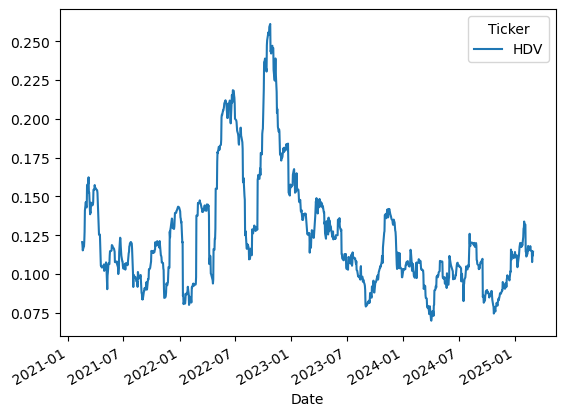

In [17]:
def standard_deviation(price_data, window=30, trading_periods=252, clean=True):

    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    result = log_return.rolling(window=window, center=False).std() * math.sqrt(
        trading_periods)

    if clean:
        return result.dropna()
    else:
        return result
standard_deviation(data).plot()

# Parkinson
Parkinson's volatility uses the stock’s high and low price of the day rather than just close to close prices. It’s useful to capture large price movements during the day.

$$ ParkinsonVolatility = \sqrt{\frac{1}{4ln(2)} \cdot \frac{1}{N}\sum_{i=1}^{N}(ln\frac{h_{i}}{l_{i}})^{2}} $$

How it works?

* Parkinson's volatility is calculated by averaging the squared logarithmic returns of an asset over a period of time.

* It uses the logarithm of the ratio of the high to low prices, which is then squared and averaged.
* This method is more comprehensive than traditional models that only use closing prices.
* It's useful for capturing large price movements during the day.

Why it's useful?
* Parkinson's volatility is considered a superior estimator because it incorporates more information.
* It's more efficient than the close-to-close volatility estimator.
* It focuses on extreme price values, which are more likely to represent substantial price movements.

https://medium.com/@jpolec_72972/improve-your-trading-parkinson-historical-volatility-d7732a6c9cc0

In [19]:
# Download SPY data from Yahoo Finance
hdv_data = yf.download('HDV', start='2021-01-01', end='2025-01-24')
# Calculate Parkinson Historical Volatility
hdv_data['Log_High_Low'] = np.log(hdv_data['High'] / hdv_data['Low']) ** 2
parkinson_volatility = np.sqrt((1 / (4 * np.log(2))) * hdv_data['Log_High_Low'].mean())
print(f"---Parkinson Historical Volatility of HDV: {parkinson_volatility}")

[*********************100%***********************]  1 of 1 completed

---Parkinson Historical Volatility of HDV: 0.00683066867092175


Ticker           HDV
Date                
2021-02-16  0.106970
2021-02-17  0.101958
2021-02-18  0.098226
2021-02-19  0.094791
2021-02-22  0.095635
...              ...
2025-02-24  0.094021
2025-02-25  0.089550
2025-02-26  0.089987
2025-02-27  0.090019
2025-02-28  0.092529

[1015 rows x 1 columns]


<Axes: xlabel='Date'>

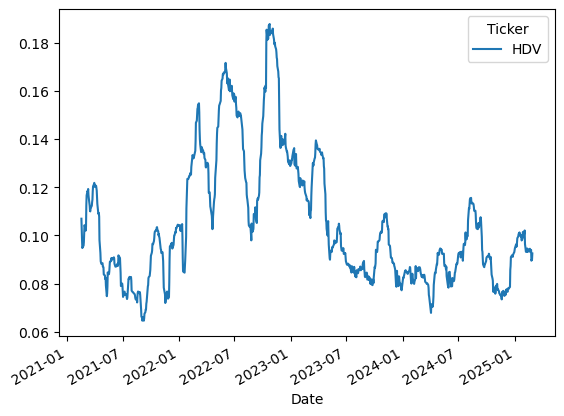

In [21]:
def parkinson(price_data, window=30, trading_periods=252, clean=True):

    rs = (1.0 / (4.0 * math.log(2.0))) * (
        (price_data["High"] / price_data["Low"]).apply(np.log)
    ) ** 2.0

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result
print(parkinson(data))
parkinson(data).plot()

# Garman-Klass
Garman-Klass volatility extends Parkinson's volatility by taking into account the opening and closing price. As markets are most active during the opening and closing of a trading session, it makes volatility estimation more accurate.


<Axes: xlabel='Date'>

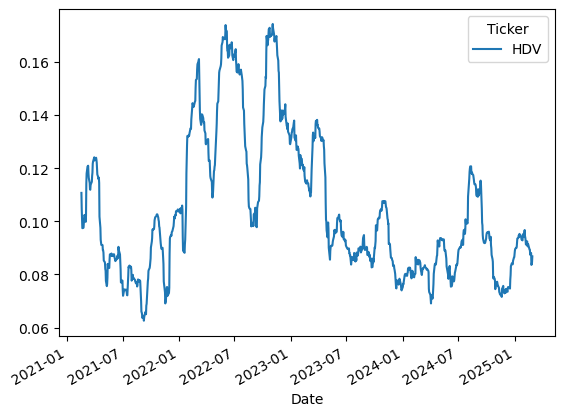

In [23]:
def garman_klass(price_data, window=30, trading_periods=252, clean=True):

    log_hl = (price_data["High"] / price_data["Low"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    rs = 0.5 * log_hl ** 2 - (2 * math.log(2) - 1) * log_co ** 2

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result
garman_klass(data).plot()